# How to generate continuous gravitational-wave signals

This notebook presents a quick hands-on introduction on generating your very own set of continuous gravitational-wave signals (CWs).

We recommend having a look at [the PyFstat tutorials](https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052) for a more in-depth introduction to the topic.

1. [Parameters](#1)
2. [Generating data](#2)
3. [Generating specific frequency bands](#3)

In [ ]:
# Kaggle notebooks run on Python 3.7, which was dropped by PyFstat a few relases back.
# Please, use the following command to install PyFstat on a Kaggle notebook.
# This will install an up-to-date version of PyFstat with Python 3.7 support.
# Do use the latest version of PyFstat if you use your own Python >= 3.8 installation.
!pip install git+https://github.com/PyFstat/PyFstat@python37

  Cloning https://github.com/PyFstat/PyFstat (to revision python37) to /tmp/pip-req-build-en_7lc_h
  Running command git clone --filter=blob:none --quiet https://github.com/PyFstat/PyFstat /tmp/pip-req-build-en_7lc_h
  Running command git checkout -b python37 --track origin/python37
  Switched to a new branch 'python37'
  Branch 'python37' set up to track remote branch 'python37' from 'origin'.
  Resolved https://github.com/PyFstat/PyFstat to commit 73ad1acdc9385a234727abf3eb9f93c9298fc5e5
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 444.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ |

In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import pyfstat

from scipy import stats

%matplotlib inline

<a id="1"></a> <br>
# 1. Parameters

Standard CW signals can be parameterised in terms of two sets of parameters: the Doppler-modulation parameters $\lambda$ and the amplitude parameters $\mathcal{A}$.
The former encode how the frequency of a signal modulates due to its intrinsic frequency evolution and the movement of the Earth in the Solar system, 
while the latter describes the overall amplitude of a CW depending on the parameters of the source.

For a CW emmitted by a rapidly-spinning and isolated neutron star (NS), Doppler-modulation parameters include the frequency `F0` and the linear spindown parameter `F1`,
both taken at a reference time `tref`, and the sky position in terms of the right ascension `Alpha` and declination `Delta` angles of equatorial cordinates. 
Amplitude parameters, on the other hand, include the average amplitude of a CW signal `h0`, the initial phase of the signal `phi`, the polarization angle `psi`
and (the cosine of) the inclination angle of the source `cosi`, which gives us the relative orientation of the NS with respect to the detector.

As described in [the signal tutorial](https://github.com/PyFstat/PyFstat/blob/master/examples/tutorials/1_generating_signals.ipynb),
the amplitude of a CW signal is usually expressed in terms of the noises's amplitude using depth $\mathcal{D}$ or signal-to-noise ratio (SNR) $\rho$.
For our purposes, the former is essentially a quotient
$$
\mathcal{D} = \frac{\sqrt{S_{\mathrm{n}}}}{h_0}
$$
while the latter is a more involved expression wich also depends on the duration of the dataset at hand and the detector's response function.
It is important to note, however, that $\rho$ and $\mathcal{D}$ scale reciprocally: "weak" signals have a *low* SNR and a *high* depth (since they are "buried deeper into the noise" than a strong signal).

<a id="2"></a> <br>
# 2. Generating data

A specific sample requires of background noise and optionally a signal. 
In order to generate noise, one needs to specify a set of `detectors` (`H1` or `L1` in this case), the duration of the sample and the Amplitude Spectral Density of the noise `sqrtSX`. 
CW analyses are simple in this front, as `sqrtSX` is proportional to the (stationary) standard deviation of an underlying zero-mean Gaussian process.

Sample duration can be specified in two ways. If the sample contains contiguous data (i.e. the detector was taking science-quality data uninterrupted), one can simply specify the starting time and duration of the sample using `tstart` and `duration`. Data with gaps, on the other hand, can be generated by specifying a specific set of timestamps using the `timestamps` option.

Data is saved as a list of Short Fourier Transforms (SFTs). The duration and windowing of these SFTs can also be modified using `Tsft`, `SFTWindowType` and `SFTWindowBeta`.
Most analyses tune `Tsft` around 1800 seconds order to ensure the power of a putative CW signal stays within a bin.

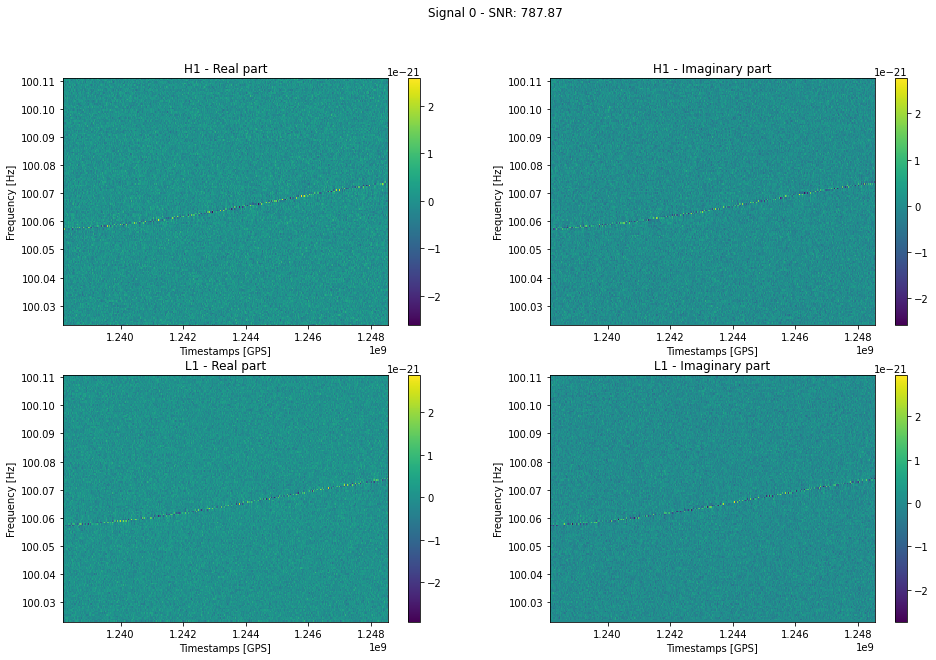

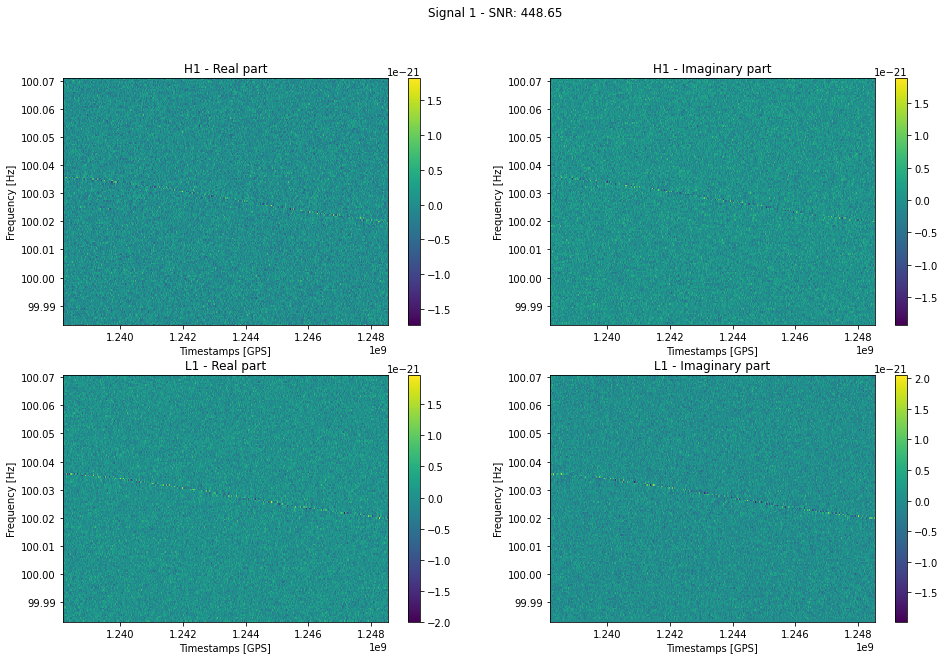

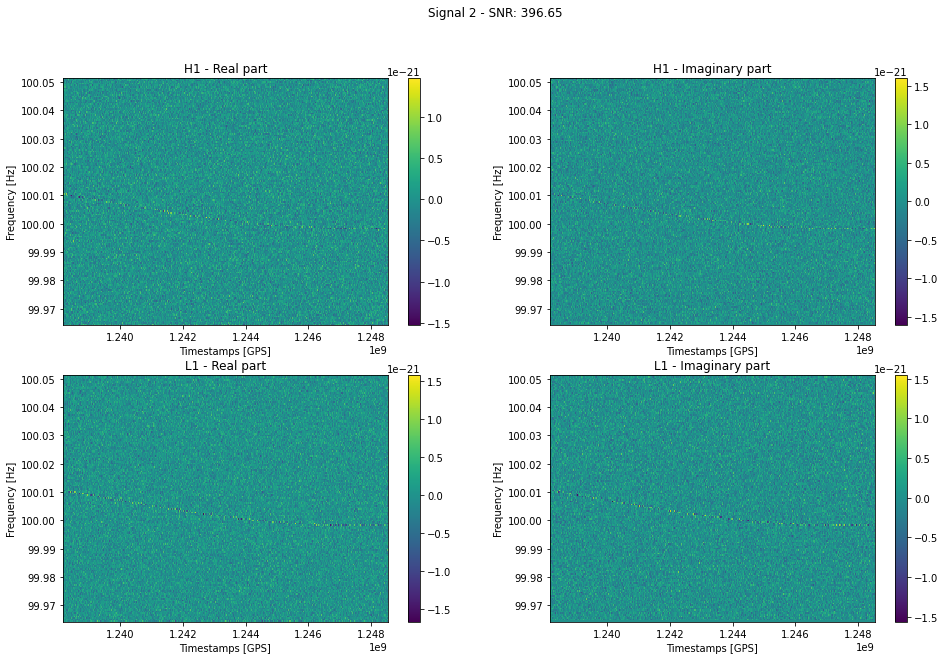

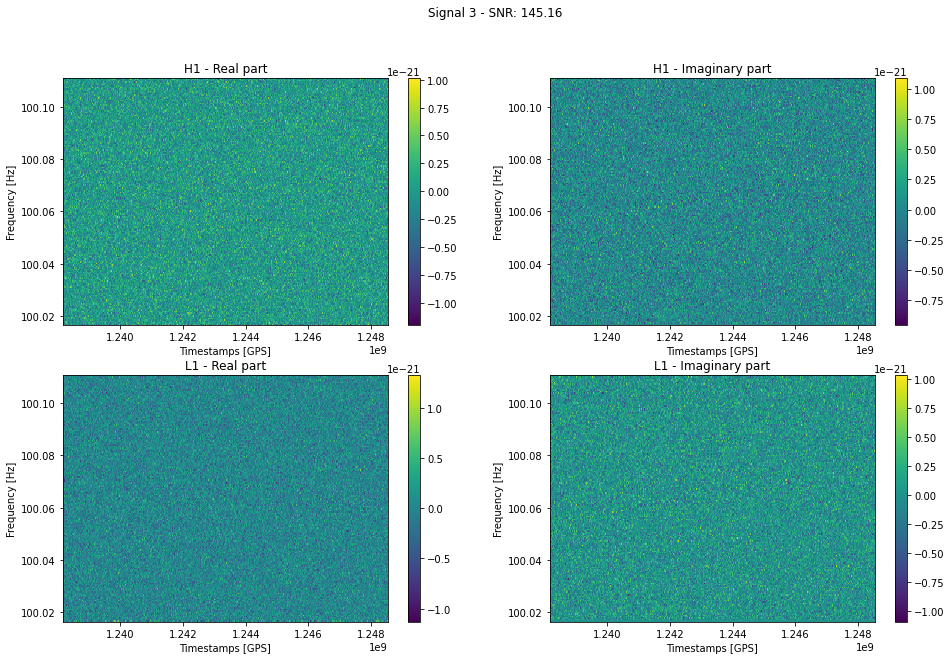

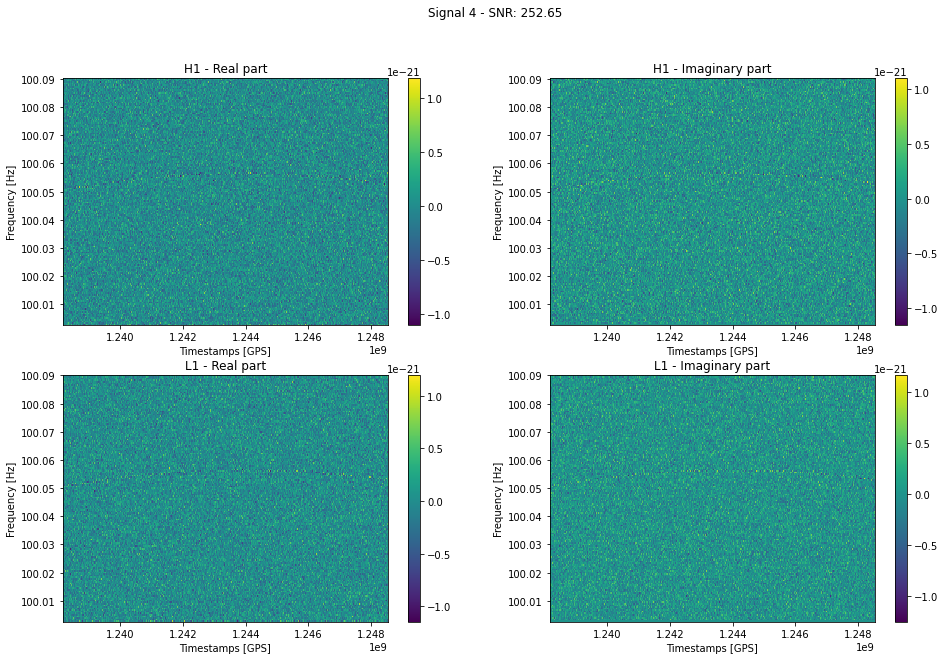

In [ ]:
# Generate signals with parameters drawn from a specific population
num_signals = 5

# These parameters describe background noise and data format
writer_kwargs = {
                "tstart": 1238166018,
                "duration": 4 * 30 * 86400,  
                "detectors": "H1,L1",        
                "sqrtSX": 1e-23,          
                "Tsft": 1800,             
                "SFTWindowType": "tukey", 
                "SFTWindowBeta": 0.01,
               }

# This class allows us to sample signal parameters from a specific population.
# Implicitly, sky positions are drawn uniformly across the celestial sphere.
# PyFstat also implements a convenient set of priors to sample a population
# of isotropically oriented neutron stars.
signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
    priors={
        "tref": writer_kwargs["tstart"],
        "F0": {"uniform": {"low": 100.0, "high": 100.1}},
        "F1": lambda: 10**stats.uniform(-12, 4).rvs(),
        "F2": 0,
        "h0": lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 10).rvs(),
        **pyfstat.injection_parameters.isotropic_amplitude_priors,
    },
)

snrs = np.zeros(num_signals)

for ind in range(num_signals):

    # Draw signal parameters.
    # Noise can be drawn by setting `params["h0"] = 0
    params = signal_parameters_generator.draw()
    writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{ind}"
    writer_kwargs["label"] = f"Signal_{ind}"
    
    writer = pyfstat.Writer(**writer_kwargs, **params)
    writer.make_data()
    
    # SNR can be compute from a set of SFTs for a specific set
    # of parameters as follows:
    snr = pyfstat.SignalToNoiseRatio.from_sfts(
        F0=writer.F0, sftfilepath=writer.sftfilepath
    )
    squared_snr = snr.compute_snr2(
        Alpha=writer.Alpha, 
        Delta=writer.Delta,
        psi=writer.psi,
        phi=writer.phi, 
        h0=writer.h0,
        cosi=writer.cosi
    )
    snrs[ind] = np.sqrt(squared_snr)
    
    # Data can be read as a numpy array using PyFstat
    frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
        writer.sftfilepath
    )
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Signal {ind} - SNR: {snrs[ind]:.2f}")
    for d_ind, detector in enumerate(amplitudes.keys()):
        ax[d_ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[d_ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        c0 = ax[d_ind][0].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].real)
        c1 = ax[d_ind][1].pcolormesh(timestamps[detector], frequency,
                                     amplitudes[detector].imag)
        
        fig.colorbar(c0, ax=ax[d_ind][0])
        fig.colorbar(c1, ax=ax[d_ind][1])
    plt.show()

<a id="3"></a> <br>
# 3. Generating specific frequency bands

The `pyfstat.Writer` class generates CW signals following the conventions used by LIGO data-analysis codes; more specifically, frequency bands are always made wide enough so that any requested CW signal can fit into it and there are enough extra bins to compute running quantities. This may be a problem, as in some cases data with a very specific frequency band may need to be generated.

A simple way to generate specific output would be to generate a broad SFT and slice the frequency band of interest whenever reading as a numpy array.
This can be done as follows (taken from [this conversation with DennisSakva](https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052#1986395):

1. Use `Writer` to generate noise-only SFTs, using Band and F0 to specify a broad frequency band [F0 - Band/2, F0 + Band/2]
2. Use another `Writer` to inject a signal in the previous SFTs via the `noiseSFTs` option. This will return the same band as the original SFTs.
3. Read into numpy array and select the band of interest

Below there is an example to generate a signal within the [150., 150.2) Hz band:

In [ ]:
# Generate SFTs noise-only SFTs covering the band of interest
noise_kwargs = {
    "tstart": 1238166018,
    "duration": 4 * 30 * 86400,
    "sqrtSX": 1e-23,
    "detectors": "H1,L1",
    "Tsft": 1800,
    "F0": 150.1, # No signals: [F0 - Band/2, F0 + Band/2]
    "Band": 0.5, 
    "SFTWindowType": "tukey",
    "SFTWindowBeta": 0.001,
}

noise_writer = pyfstat.Writer(label="custom_band_noise", **noise_kwargs)
noise_writer.make_data()

# Inject signal into noise SFTs. Note the lack of `Band` argument.
signal_kwargs = {
        "noiseSFTs": noise_writer.sftfilepath,
        "F0": 150.15,
        "F1": 1e-8,
        "Alpha": 0.3,
        "Delta": 0,
        "h0": 1e-23/10,
        "cosi": 1,
        "psi": 0.2,
        "phi": 0.
        }
for key in ["SFTWindowType", "SFTWindowBeta"]:
    signal_kwargs[key] = noise_kwargs[key]

signal_writer = pyfstat.Writer(label="custom_band_signal", **signal_kwargs)
signal_writer.make_data()

# Slice out the band of interest
freqs, times, sft_data = pyfstat.utils.get_sft_as_arrays(signal_writer.sftfilepath)

first_index = np.argmin(np.abs(freqs - 150.))
last_index = np.argmin(np.abs(freqs - 150.2))

freqs = freqs[first_index:last_index+1]
amplitudes = {key: val[first_index:last_index + 1, :]
        for key, val in sft_data.items()}

freqs

array([150.        , 150.00055556, 150.00111111, 150.00166667,
       150.00222222, 150.00277778, 150.00333333, 150.00388889,
       150.00444444, 150.005     , 150.00555556, 150.00611111,
       150.00666667, 150.00722222, 150.00777778, 150.00833333,
       150.00888889, 150.00944444, 150.01      , 150.01055556,
       150.01111111, 150.01166667, 150.01222222, 150.01277778,
       150.01333333, 150.01388889, 150.01444444, 150.015     ,
       150.01555556, 150.01611111, 150.01666667, 150.01722222,
       150.01777778, 150.01833333, 150.01888889, 150.01944444,
       150.02      , 150.02055556, 150.02111111, 150.02166667,
       150.02222222, 150.02277778, 150.02333333, 150.02388889,
       150.02444444, 150.025     , 150.02555556, 150.02611111,
       150.02666667, 150.02722222, 150.02777778, 150.02833333,
       150.02888889, 150.02944444, 150.03      , 150.03055556,
       150.03111111, 150.03166667, 150.03222222, 150.03277778,
       150.03333333, 150.03388889, 150.03444444, 150.03